In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import seaborn as sns   
import matplotlib.pyplot as plt

train_features = pd.read_csv("train_features.csv").sort_values(by='pid')
test = pd.read_csv("test_features.csv")
train_labels = pd.read_csv("train_labels.csv").sort_values(by='pid')

/home/aizardar/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train_labels.head()

pid  LABEL_BaseExcess  LABEL_Fibrinogen  LABEL_AST  LABEL_Alkalinephos  \
0        1               1.0               0.0        0.0                 0.0   
6622     2               0.0               0.0        0.0                 0.0   
15008    4               0.0               0.0        0.0                 0.0   
16335    6               1.0               0.0        0.0                 0.0   
17676    8               0.0               0.0        0.0                 0.0   

       LABEL_Bilirubin_total  LABEL_Lactate  LABEL_TroponinI  LABEL_SaO2  \
0                        0.0            1.0              0.0         0.0   
6622                     0.0            0.0              1.0         0.0   
15008                    0.0            0.0              0.0         1.0   
16335                    0.0            0.0              0.0         1.0   
17676                    0.0            0.0              0.0         0.0   

       LABEL_Bilirubin_direct  LABEL_EtCO2  LABEL_Sepsis  LABEL_RRate  \
0                         0.0          0.0           0.0         12.1   
6622                      0.0          0.0           0.0         20.4   
15008                     0.0          0.0           0.0         17.8   
16335                     0.0          0.0           0.0         17.9   
17676                     0.0          0.0           0.0         18.7   

       LABEL_ABPm  LABEL_SpO2  LABEL_Heartrate  
0            85.4       100.0             59.9  
6622         99.1        95.4             65.8  
15008        78.8        97.4             71.8  
16335        75.1        97.3             80.7  
17676       112.8        97.0             92.6

In [3]:
# Let's first look at the class imbalance

TESTS = ['LABEL_BaseExcess', 'LABEL_Fibrinogen', 'LABEL_AST', 'LABEL_Alkalinephos', 'LABEL_Bilirubin_total',
         'LABEL_Lactate', 'LABEL_TroponinI', 'LABEL_SaO2',
         'LABEL_Bilirubin_direct', 'LABEL_EtCO2','LABEL_Sepsis']

for labels in TESTS:
    neg, pos = np.bincount(train_labels[labels])
    total = neg + pos
    print('Label:{}\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(labels, total, pos, 100 * pos / total))

Label:LABEL_BaseExcess
    Total: 18995
    Positive: 5096 (26.83% of total)

Label:LABEL_Fibrinogen
    Total: 18995
    Positive: 1400 (7.37% of total)

Label:LABEL_AST
    Total: 18995
    Positive: 4554 (23.97% of total)

Label:LABEL_Alkalinephos
    Total: 18995
    Positive: 4487 (23.62% of total)

Label:LABEL_Bilirubin_total
    Total: 18995
    Positive: 4570 (24.06% of total)

Label:LABEL_Lactate
    Total: 18995
    Positive: 3803 (20.02% of total)

Label:LABEL_TroponinI
    Total: 18995
    Positive: 1895 (9.98% of total)

Label:LABEL_SaO2
    Total: 18995
    Positive: 4439 (23.37% of total)

Label:LABEL_Bilirubin_direct
    Total: 18995
    Positive: 644 (3.39% of total)

Label:LABEL_EtCO2
    Total: 18995
    Positive: 1254 (6.60% of total)

Label:LABEL_Sepsis
    Total: 18995
    Positive: 1088 (5.73% of total)



### This shows we are dealing with class imbalance !

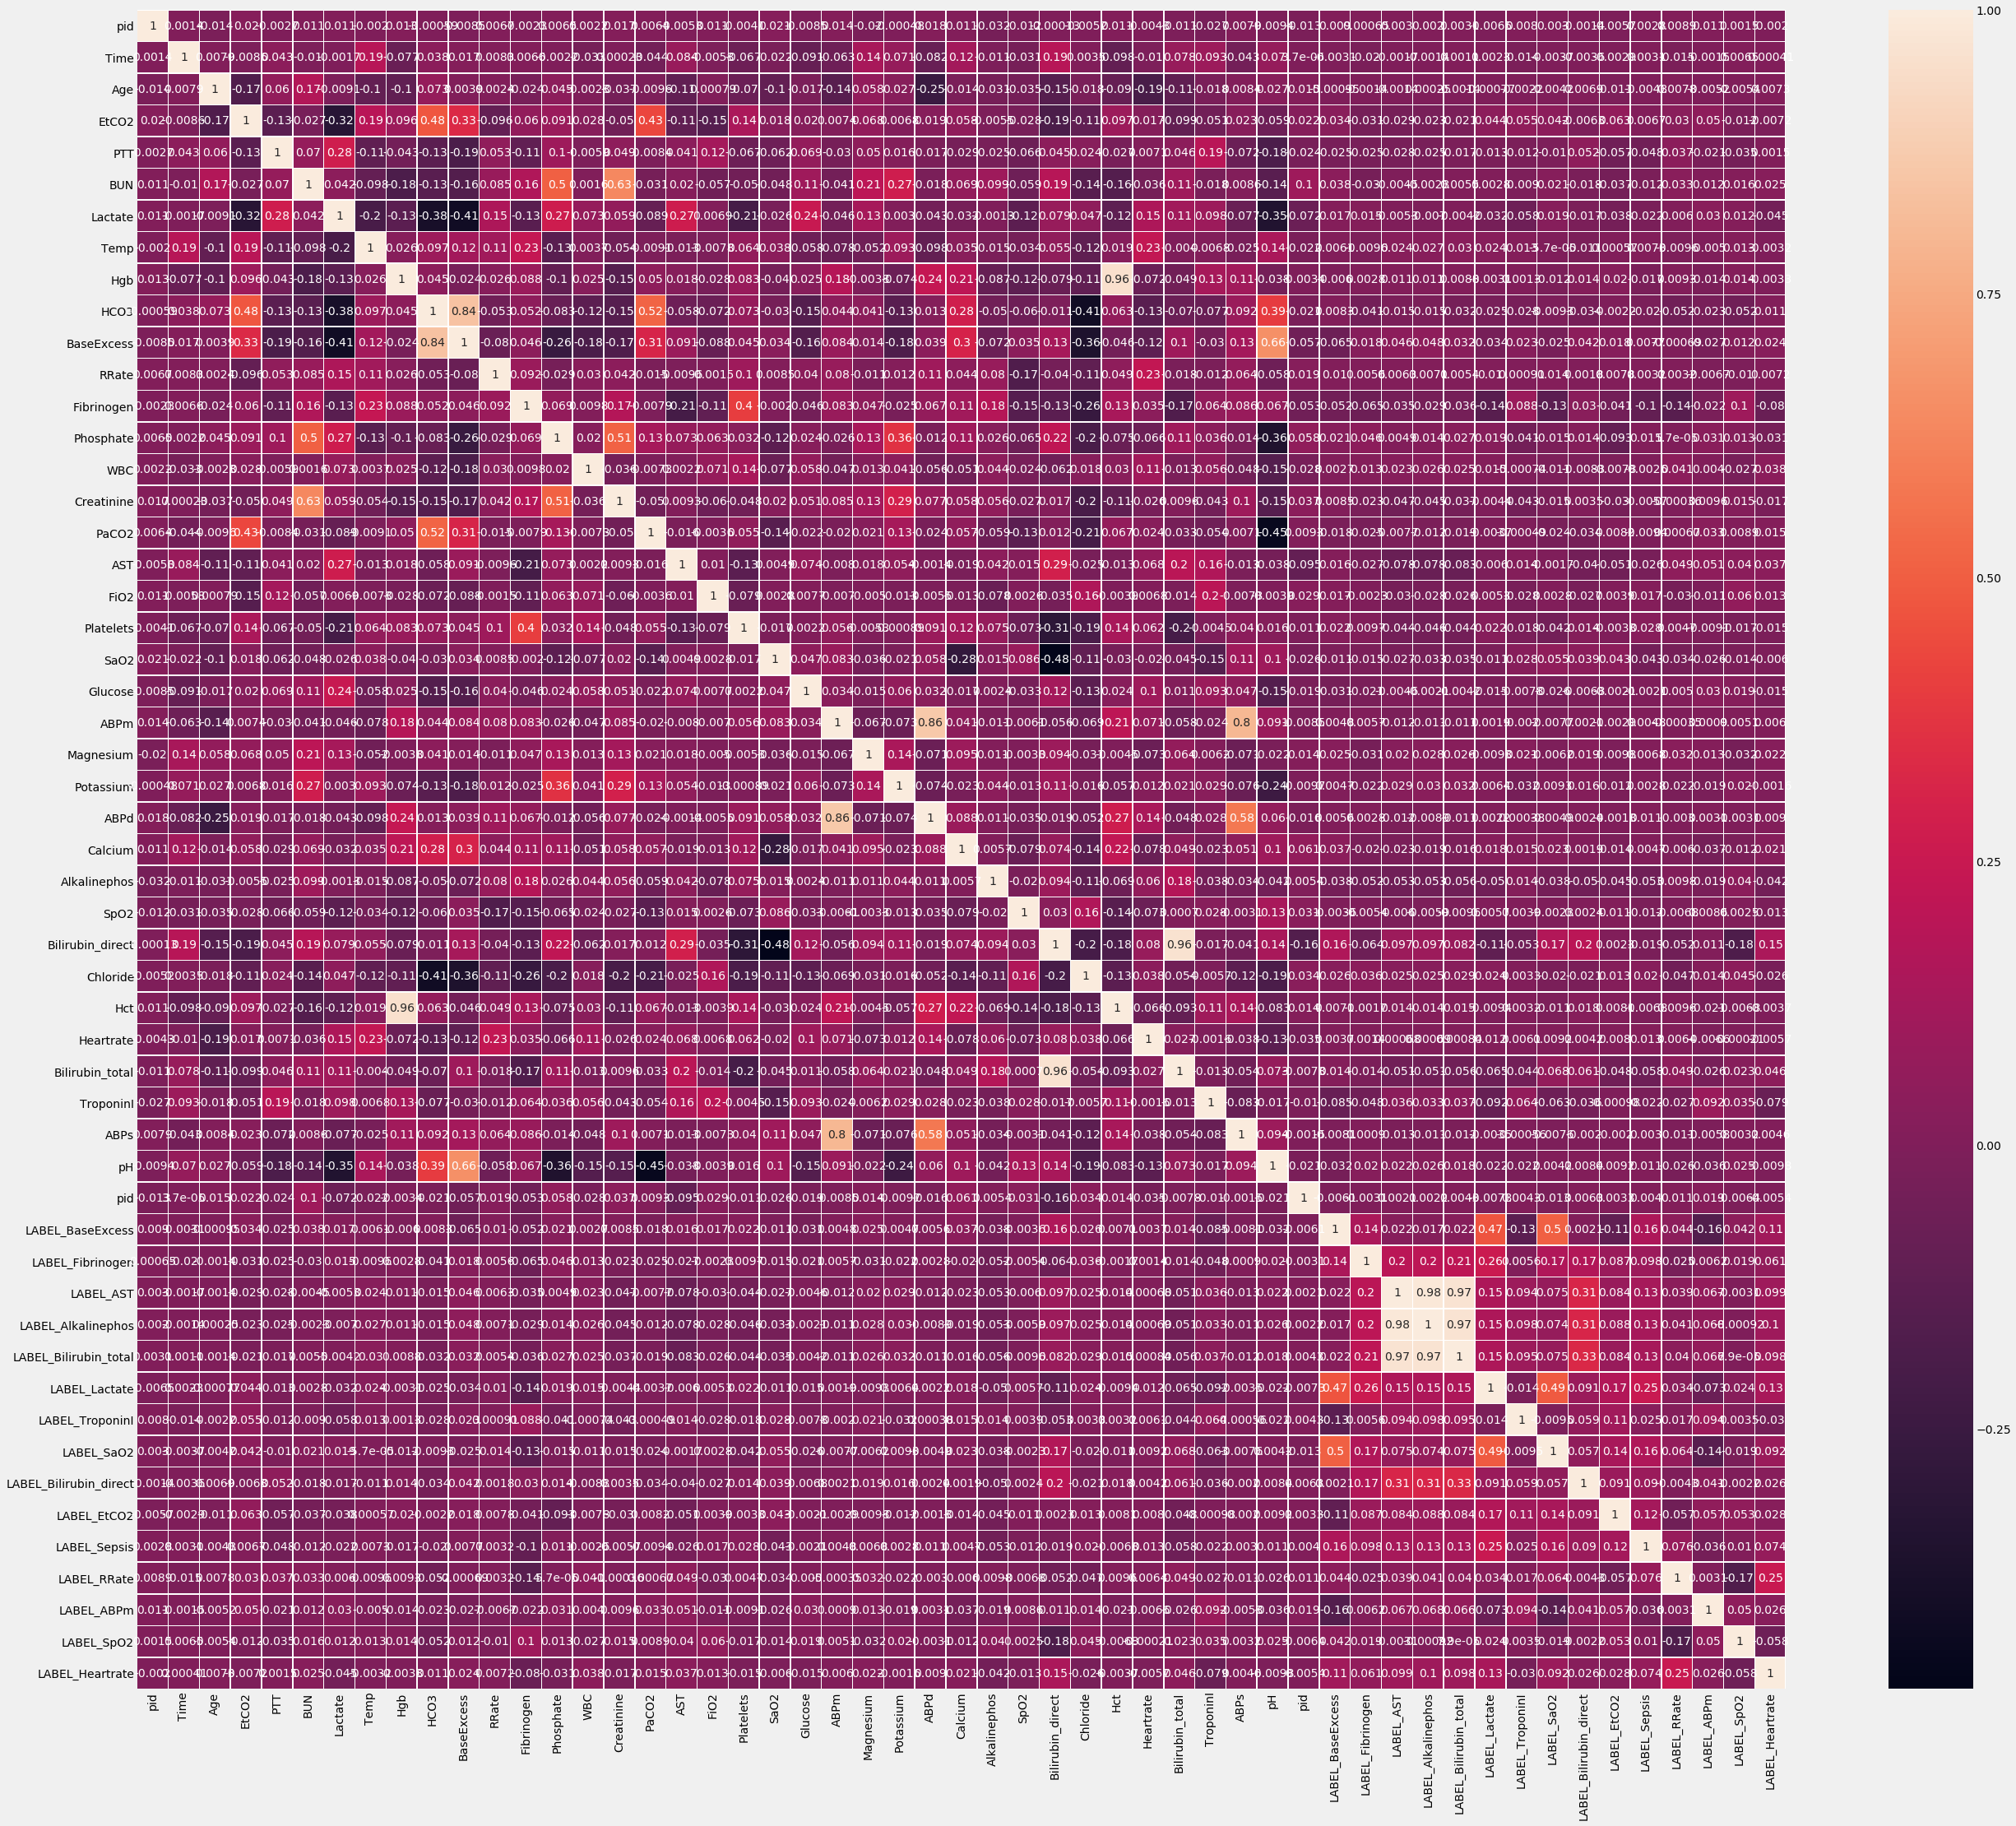

In [4]:
# Let's now look at the correlation heatmap of the train data 

def corr_check(data):
    
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(40,35))         # Sample figsize in inches
    sns.heatmap(data.corr(), linewidths=.5, ax=ax, annot= True)
    plt.show()
    
raw_data = pd.concat([train_features, train_labels], axis=1, sort=False)
corr_check(raw_data)

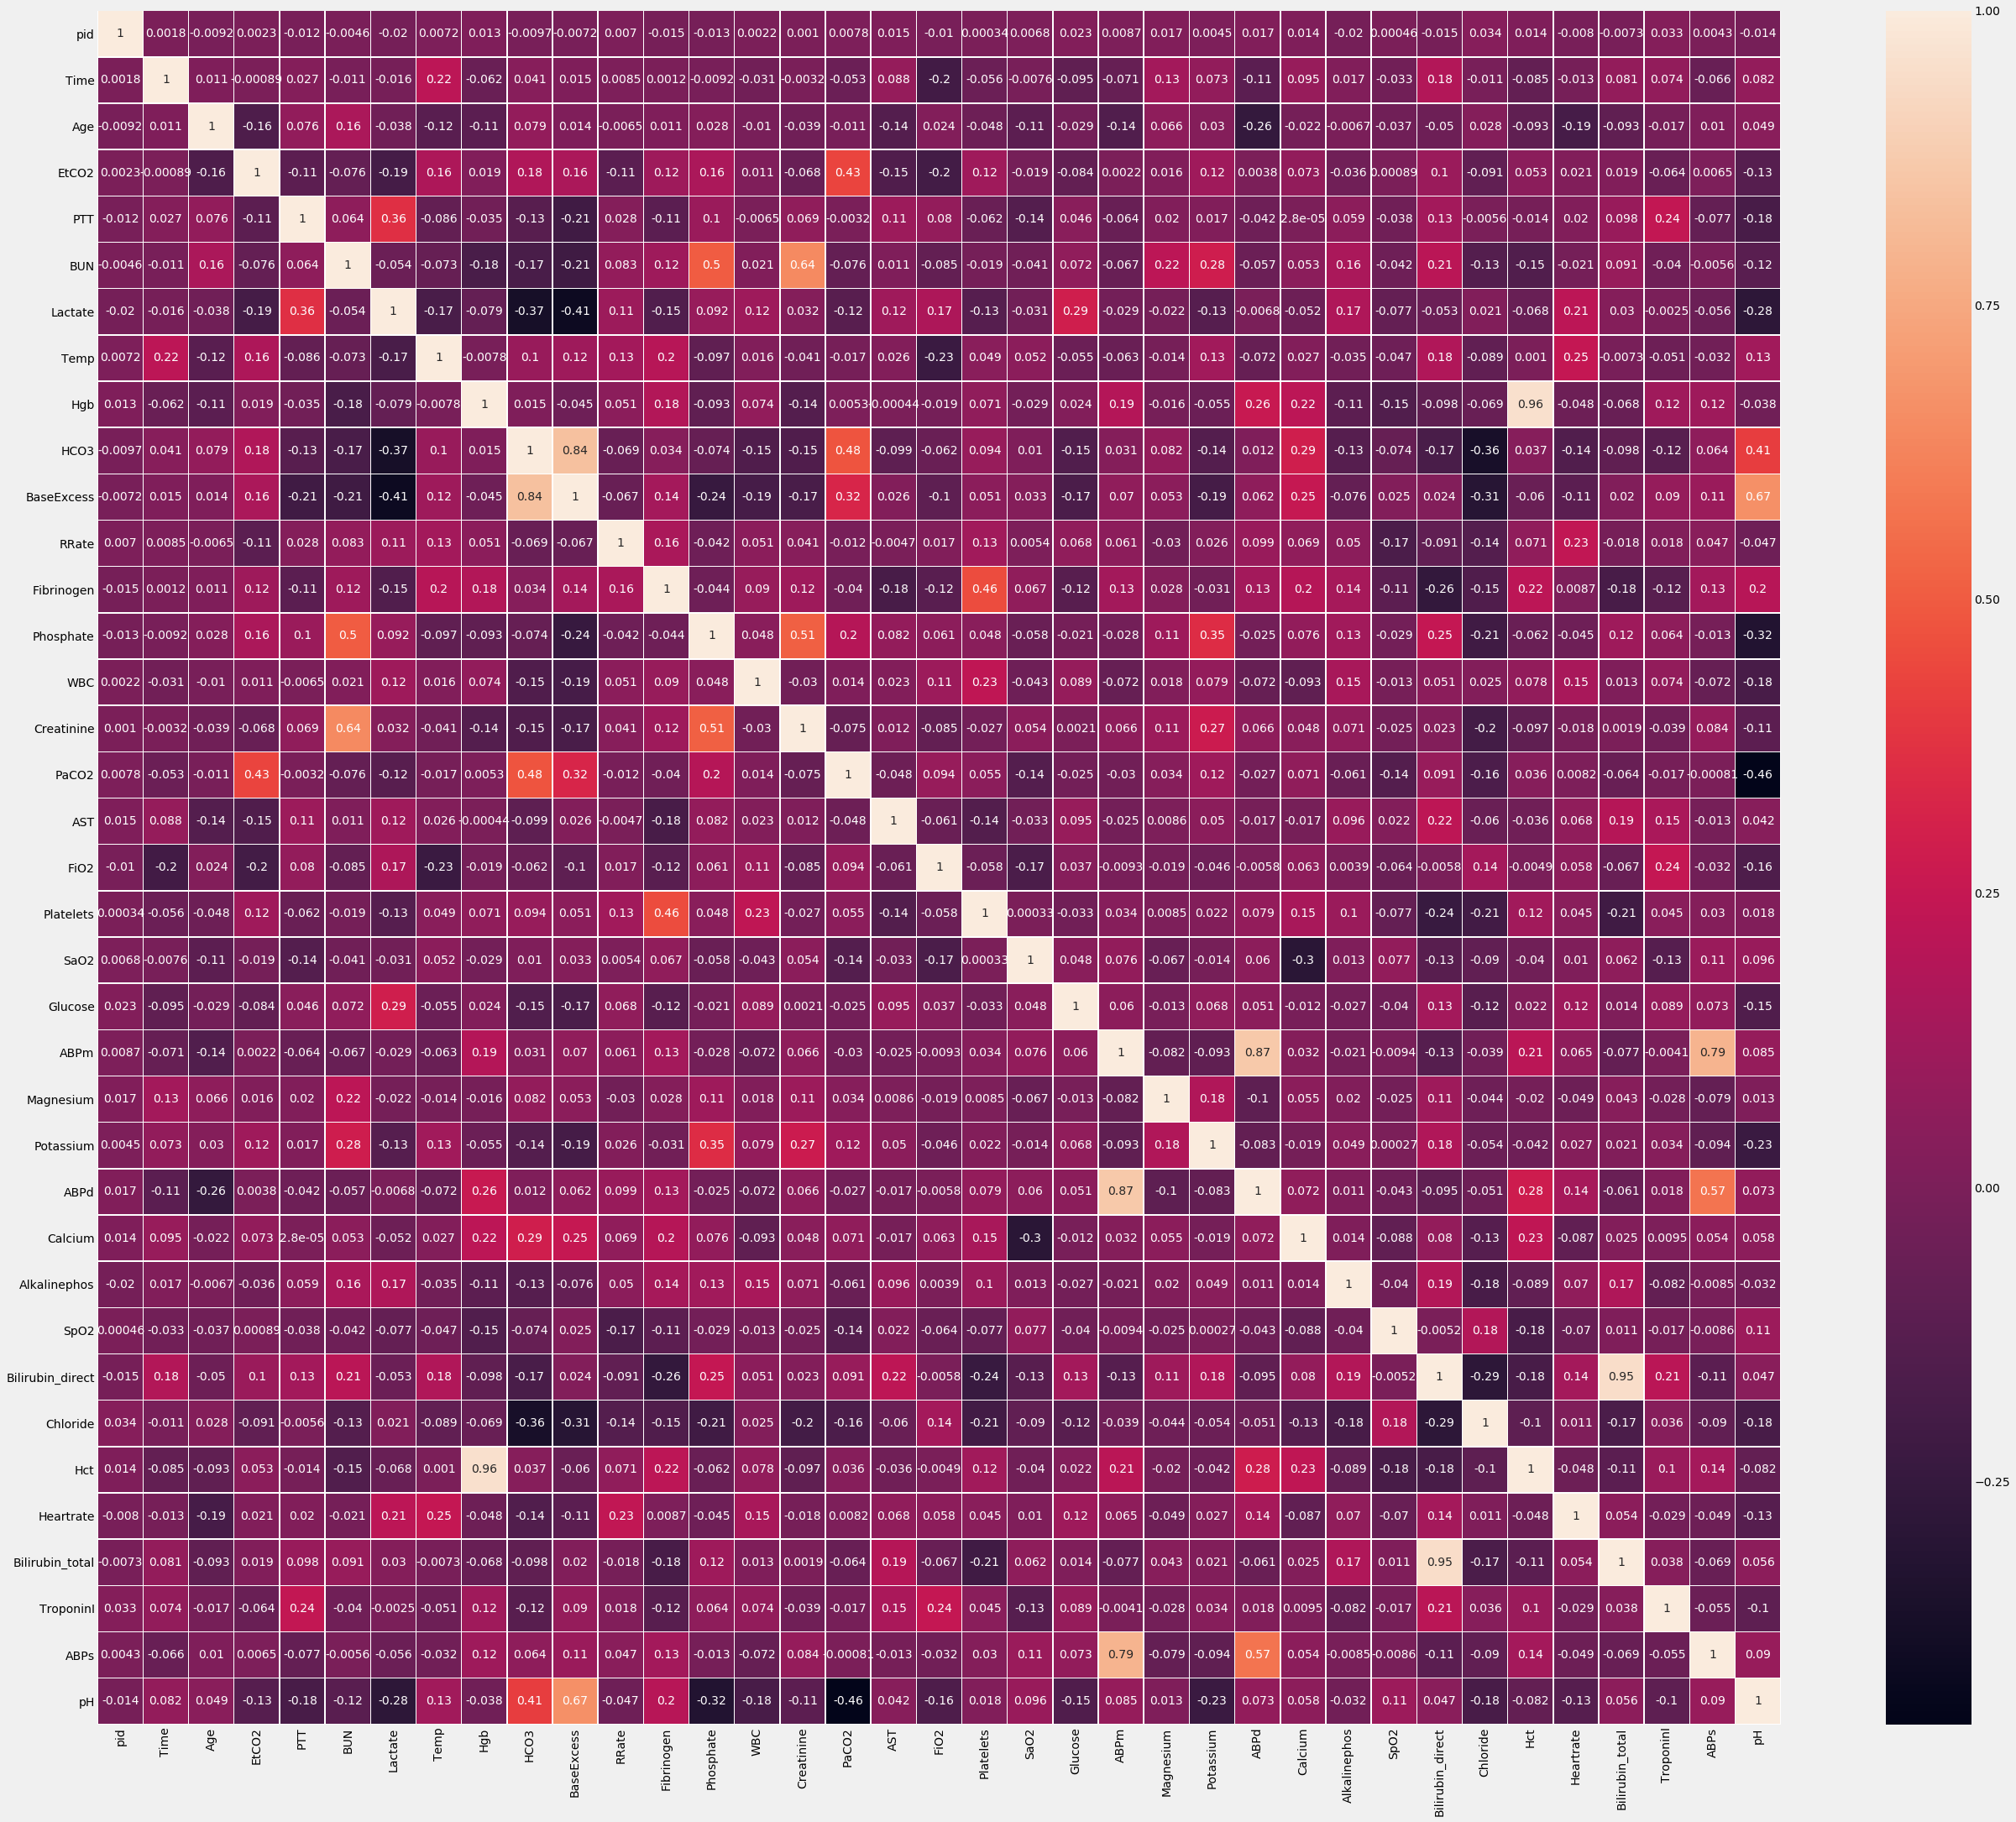

In [5]:
# Let's now look at the correlation heatmap of the test data 

corr_check(test)

In [6]:
# There seem to be correlation between some features. Let's remove them !

# Let's get rid of Hgb, HCO3, ABPd, and Bilirubin_direct from the training and test data !

# train_features.drop('Bilirubin_direct', axis=1, inplace=True)
# train_features.drop('HCO3', axis=1, inplace=True)
# train_features.drop('Hgb', axis=1, inplace=True)
# train_features.drop('ABPd', axis=1, inplace=True)

# test.drop('Bilirubin_direct', axis=1, inplace=True)
# test.drop('HCO3', axis=1, inplace=True)
# test.drop('Hgb', axis=1, inplace=True)
# test.drop('ABPd', axis=1, inplace=True) 

In [ ]:
# corr_check(test)

In [ ]:
# corr_check(train_features)

## We need to impute data to both training and test set. Let's do it per pid. We will use KNN imputer from sklearn

In [7]:
from sklearn.impute import KNNImputer

In [8]:
def impute_KNN(df):
    imputed_df = pd.DataFrame(columns=df.columns)
    imp = sklearn.impute.KNNImputer(n_neighbors=1)
    for pid in tqdm(np.unique(df['pid'].values)):
        temp_df = df.loc[df['pid'] == pid]
        temp_df2 = temp_df.dropna(axis = 'columns', how = 'all')
        imp.fit(temp_df2)
        temp_df2 = pd.DataFrame(data = imp.transform(temp_df2), columns = temp_df2.columns)
        for key in temp_df.columns:
            if temp_df[key].isna().all():
                temp_df2[key] = np.nan
        imputed_df = imputed_df.append(temp_df2, sort = True)
    imputed_df.reindex(columns = df.columns)
    return imputed_df

In [9]:
train_features_imp = impute_KNN(train_features)


100%|██████████| 18995/18995 [08:28<00:00, 37.34it/s]


In [10]:
train_features_imp.head(30)

ABPd   ABPm   ABPs   AST   Age  Alkalinephos   BUN  BaseExcess  \
0   61.0   84.0  142.0   NaN  34.0           NaN  12.0        -2.0   
1   49.0   69.0  124.0   NaN  34.0           NaN  12.0         0.0   
2   44.0   62.0  110.0   NaN  34.0           NaN  12.0         0.0   
3   47.0   67.0  118.0   NaN  34.0           NaN  12.0         0.0   
4   47.0   68.0  121.0   NaN  34.0           NaN  12.0         0.0   
5   46.0   65.0  112.0   NaN  34.0           NaN  12.0         0.0   
6   39.0   53.0  102.0   NaN  34.0           NaN  12.0         0.0   
7   48.0   63.0  100.0   NaN  34.0           NaN  12.0         0.0   
8   49.5   66.0  104.0   NaN  34.0           NaN  12.0         0.0   
9   59.0   74.0  110.0   NaN  34.0           NaN  12.0         0.0   
10  62.5   81.0  125.0   NaN  34.0           NaN  12.0        -2.0   
11  51.0   68.0  106.0   NaN  34.0           NaN  12.0         0.0   
0   76.0   99.0  136.0   NaN  86.0           NaN  32.0         NaN   
1   58.0   84.0  127.0   NaN  86.0           NaN  32.0         NaN   
2   66.0   95.0  140.0   NaN  86.0           NaN  32.0         NaN   
3   79.0   96.0  120.0   NaN  86.0           NaN  32.0         NaN   
4   62.0   86.0  122.0   NaN  86.0           NaN  32.0         NaN   
5   72.0  100.0  138.0   NaN  86.0           NaN  32.0         NaN   
6   72.0   97.0  132.0   NaN  86.0           NaN  32.0         NaN   
7   65.0   89.0  125.0   NaN  86.0           NaN  32.0         NaN   
8   73.0   95.0  129.0   NaN  86.0           NaN  32.0         NaN   
9   71.0   94.0  126.0   NaN  86.0           NaN  32.0         NaN   
10  77.0  106.0  148.0   NaN  86.0           NaN  32.0         NaN   
11  77.0  106.0  148.0   NaN  86.0           NaN  32.0         NaN   
0   42.0   60.0   98.0  34.0  66.0         130.0   8.0         NaN   
1   44.0   62.0   96.0  34.0  66.0         130.0   8.0         NaN   
2   50.0   74.0  146.0  34.0  66.0         130.0   8.0         NaN   
3   50.0   74.0  146.0  34.0  66.0         130.0   8.0         NaN   
4   52.0   82.0  160.0  34.0  66.0         130.0   8.0         NaN   
5   70.0  164.0  166.0  34.0  66.0         130.0   8.0         NaN   

    Bilirubin_direct  Bilirubin_total  ...  Potassium  RRate  SaO2   SpO2  \
0                NaN              NaN  ...        3.8   16.0   NaN  100.0   
1                NaN              NaN  ...        4.1   18.0   NaN  100.0   
2                NaN              NaN  ...        4.1   18.0   NaN  100.0   
3                NaN              NaN  ...        4.1   12.0   NaN  100.0   
4                NaN              NaN  ...        4.1   18.0   NaN  100.0   
5                NaN              NaN  ...        4.1   18.0   NaN  100.0   
6                NaN              NaN  ...        4.1   18.0   NaN  100.0   
7                NaN              NaN  ...        4.1   18.0   NaN  100.0   
8                NaN              NaN  ...        4.1   18.0   NaN  100.0   
9                NaN              NaN  ...        4.1   18.0   NaN  100.0   
10               NaN              NaN  ...        3.8   16.0   NaN  100.0   
11               NaN              NaN  ...        4.1   16.0   NaN  100.0   
0                NaN              NaN  ...        3.8   19.0   NaN   94.0   
1                NaN              NaN  ...        3.8   22.0   NaN   95.0   
2                NaN              NaN  ...        3.8   24.0   NaN   94.0   
3                NaN              NaN  ...        3.8   12.0   NaN   97.0   
4                NaN              NaN  ...        3.8   12.0   NaN   97.0   
5                NaN              NaN  ...        3.8   19.0   NaN   98.0   
6                NaN              NaN  ...        3.8   13.0   NaN   96.0   
7                NaN              NaN  ...        3.8   20.0   NaN   95.0   
8                NaN              NaN  ...        3.8   12.0   NaN   98.0   
9                NaN              NaN  ...        3.8   21.0   NaN   96.0   
10               NaN              NaN  ...        3.8   24.0  

In [11]:
test_imputed = impute_KNN(test)

100%|██████████| 12664/12664 [05:19<00:00, 39.63it/s]


In [12]:
test_imputed.head(30)

ABPd   ABPm   ABPs   AST   Age  Alkalinephos   BUN  BaseExcess  \
0    76.0   77.0  119.0  32.0  39.0         119.0  17.0        -9.0   
1    76.0   77.0  119.0  32.0  39.0         119.0  17.0        -9.0   
2    72.5   78.0  125.0  31.0  39.0         109.0  20.0        -9.0   
3    66.0   87.0  136.0  31.0  39.0         109.0  20.0        -9.0   
4    65.0   86.0  135.0  31.0  39.0         109.0  20.0        -4.0   
5    66.0   89.0  144.0  31.0  39.0         109.0  20.0        -4.0   
6    59.0   80.0  129.0  31.0  39.0         109.0  20.0        -4.0   
7    59.0   80.0  129.0  31.0  39.0         109.0  20.0        -4.0   
8    56.5   75.0  121.0  31.0  39.0         109.0  20.0        -4.0   
9    55.0   74.0  120.0  31.0  39.0         109.0  20.0        -4.0   
10   55.0   74.0  120.0  31.0  39.0         109.0  20.0        -4.0   
11   55.0   74.0  120.0  31.0  39.0         109.0  20.0        -4.0   
0    57.0   62.0   82.0   NaN  84.0           NaN   NaN         NaN   
1    57.0   62.0   82.0   NaN  84.0           NaN   NaN         NaN   
2    74.0   79.0   94.0   NaN  84.0           NaN   NaN         NaN   
3    74.0   79.0   94.0   NaN  84.0           NaN   NaN         NaN   
4    74.0   79.0   94.0   NaN  84.0           NaN   NaN         NaN   
5    74.0   79.0   94.0   NaN  84.0           NaN   NaN         NaN   
6   121.0  147.0  180.0   NaN  84.0           NaN   NaN         NaN   
7   121.0  147.0  180.0   NaN  84.0           NaN   NaN         NaN   
8   121.0  147.0  180.0   NaN  84.0           NaN   NaN         NaN   
9    62.0   77.0   97.0   NaN  84.0           NaN   NaN         NaN   
10   61.0   79.0  103.0   NaN  84.0           NaN   NaN         NaN   
11   71.0   93.0  122.0   NaN  84.0           NaN   NaN         NaN   
0    56.0   80.0  127.0   NaN  62.0           NaN   NaN         NaN   
1    56.0   80.0  127.0   NaN  62.0           NaN   NaN         NaN   
2    52.0   73.0  119.0   NaN  62.0           NaN   NaN         NaN   
3    50.0   71.0  115.0   NaN  62.0           NaN   NaN         NaN   
4    49.0   66.0  100.0   NaN  62.0           NaN   NaN         NaN   
5    49.0   68.0  105.0   NaN  62.0           NaN   NaN         NaN   

    Bilirubin_direct  Bilirubin_total  ...  Potassium  RRate  SaO2   SpO2  \
0                NaN             21.8  ...        4.6   13.0   NaN  100.0   
1                NaN             21.8  ...        4.6   13.0   NaN  100.0   
2                NaN             26.4  ...        3.7   13.0   NaN  100.0   
3                NaN             26.4  ...        3.7   12.0   NaN  100.0   
4                NaN             26.4  ...        3.7   12.0   NaN  100.0   
5                NaN             26.4  ...        3.7   10.0   NaN  100.0   
6                NaN             26.4  ...        3.7   12.0   NaN  100.0   
7                NaN             26.4  ...        3.7   12.0   NaN  100.0   
8                NaN             26.4  ...        3.7   12.0   NaN  100.0   
9                NaN             26.4  ...        3.7   11.0   NaN  100.0   
10               NaN             26.4  ...        3.7   11.0   NaN  100.0   
11               NaN             26.4  ...        3.7   11.0   NaN  100.0   
0                NaN              NaN  ...        NaN   20.0   NaN   94.0   
1                NaN              NaN  ...        NaN   20.0   NaN   94.0   
2                NaN              NaN  ...        NaN   20.0   NaN   94.0   
3                NaN              NaN  ...        NaN   20.0   NaN   94.0   
4                NaN              NaN  ...        NaN   20.0   NaN   94.0   
5                NaN              NaN  ...        NaN   20.0   NaN   94.0   
6                NaN              NaN  ...        NaN   14.0   NaN  100.0   
7                NaN              NaN  ...        NaN   14.0   NaN  100.0   
8                NaN              NaN  ...        NaN   14.0   NaN  100.0   
9                NaN              NaN  ...        NaN   14.0   NaN   96.0   
10               NaN            

## We still have Nans in our training and dataset. Let's fill them with the most common value for each column(feature)

In [13]:
def impute_mode(df):
    for column in df.columns:
        df[column].fillna(df[column].mode()[0], inplace=True)
    return df

In [14]:
train_features_imp = impute_mode(train_features_imp)

In [15]:
train_features_imp.head(30)

ABPd   ABPm   ABPs   AST   Age  Alkalinephos   BUN  BaseExcess  \
0   61.0   84.0  142.0  21.0  34.0          58.0  12.0        -2.0   
1   49.0   69.0  124.0  21.0  34.0          58.0  12.0         0.0   
2   44.0   62.0  110.0  21.0  34.0          58.0  12.0         0.0   
3   47.0   67.0  118.0  21.0  34.0          58.0  12.0         0.0   
4   47.0   68.0  121.0  21.0  34.0          58.0  12.0         0.0   
5   46.0   65.0  112.0  21.0  34.0          58.0  12.0         0.0   
6   39.0   53.0  102.0  21.0  34.0          58.0  12.0         0.0   
7   48.0   63.0  100.0  21.0  34.0          58.0  12.0         0.0   
8   49.5   66.0  104.0  21.0  34.0          58.0  12.0         0.0   
9   59.0   74.0  110.0  21.0  34.0          58.0  12.0         0.0   
10  62.5   81.0  125.0  21.0  34.0          58.0  12.0        -2.0   
11  51.0   68.0  106.0  21.0  34.0          58.0  12.0         0.0   
0   76.0   99.0  136.0  21.0  86.0          58.0  32.0         0.0   
1   58.0   84.0  127.0  21.0  86.0          58.0  32.0         0.0   
2   66.0   95.0  140.0  21.0  86.0          58.0  32.0         0.0   
3   79.0   96.0  120.0  21.0  86.0          58.0  32.0         0.0   
4   62.0   86.0  122.0  21.0  86.0          58.0  32.0         0.0   
5   72.0  100.0  138.0  21.0  86.0          58.0  32.0         0.0   
6   72.0   97.0  132.0  21.0  86.0          58.0  32.0         0.0   
7   65.0   89.0  125.0  21.0  86.0          58.0  32.0         0.0   
8   73.0   95.0  129.0  21.0  86.0          58.0  32.0         0.0   
9   71.0   94.0  126.0  21.0  86.0          58.0  32.0         0.0   
10  77.0  106.0  148.0  21.0  86.0          58.0  32.0         0.0   
11  77.0  106.0  148.0  21.0  86.0          58.0  32.0         0.0   
0   42.0   60.0   98.0  34.0  66.0         130.0   8.0         0.0   
1   44.0   62.0   96.0  34.0  66.0         130.0   8.0         0.0   
2   50.0   74.0  146.0  34.0  66.0         130.0   8.0         0.0   
3   50.0   74.0  146.0  34.0  66.0         130.0   8.0         0.0   
4   52.0   82.0  160.0  34.0  66.0         130.0   8.0         0.0   
5   70.0  164.0  166.0  34.0  66.0         130.0   8.0         0.0   

    Bilirubin_direct  Bilirubin_total  ...  Potassium  RRate  SaO2   SpO2  \
0                0.1              0.6  ...        3.8   16.0  98.0  100.0   
1                0.1              0.6  ...        4.1   18.0  98.0  100.0   
2                0.1              0.6  ...        4.1   18.0  98.0  100.0   
3                0.1              0.6  ...        4.1   12.0  98.0  100.0   
4                0.1              0.6  ...        4.1   18.0  98.0  100.0   
5                0.1              0.6  ...        4.1   18.0  98.0  100.0   
6                0.1              0.6  ...        4.1   18.0  98.0  100.0   
7                0.1              0.6  ...        4.1   18.0  98.0  100.0   
8                0.1              0.6  ...        4.1   18.0  98.0  100.0   
9                0.1              0.6  ...        4.1   18.0  98.0  100.0   
10               0.1              0.6  ...        3.8   16.0  98.0  100.0   
11               0.1              0.6  ...        4.1   16.0  98.0  100.0   
0                0.1              0.6  ...        3.8   19.0  98.0   94.0   
1                0.1              0.6  ...        3.8   22.0  98.0   95.0   
2                0.1              0.6  ...        3.8   24.0  98.0   94.0   
3                0.1              0.6  ...        3.8   12.0  98.0   97.0   
4                0.1              0.6  ...        3.8   12.0  98.0   97.0   
5                0.1              0.6  ...        3.8   19.0  98.0   98.0   
6                0.1              0.6  ...        3.8   13.0  98.0   96.0   
7                0.1              0.6  ...        3.8   20.0  98.0   95.0   
8                0.1              0.6  ...        3.8   12.0  98.0   98.0   
9                0.1              0.6  ...        3.8   21.0  98.0   96.0   
10               0.1              0.6  ...        3.8   24.0  

In [16]:
test_imputed = impute_mode(test_imputed)

In [17]:
test_imputed.head(30)

ABPd   ABPm   ABPs   AST   Age  Alkalinephos   BUN  BaseExcess  \
0    76.0   77.0  119.0  32.0  39.0         119.0  17.0        -9.0   
1    76.0   77.0  119.0  32.0  39.0         119.0  17.0        -9.0   
2    72.5   78.0  125.0  31.0  39.0         109.0  20.0        -9.0   
3    66.0   87.0  136.0  31.0  39.0         109.0  20.0        -9.0   
4    65.0   86.0  135.0  31.0  39.0         109.0  20.0        -4.0   
5    66.0   89.0  144.0  31.0  39.0         109.0  20.0        -4.0   
6    59.0   80.0  129.0  31.0  39.0         109.0  20.0        -4.0   
7    59.0   80.0  129.0  31.0  39.0         109.0  20.0        -4.0   
8    56.5   75.0  121.0  31.0  39.0         109.0  20.0        -4.0   
9    55.0   74.0  120.0  31.0  39.0         109.0  20.0        -4.0   
10   55.0   74.0  120.0  31.0  39.0         109.0  20.0        -4.0   
11   55.0   74.0  120.0  31.0  39.0         109.0  20.0        -4.0   
0    57.0   62.0   82.0  20.0  84.0          66.0  14.0         0.0   
1    57.0   62.0   82.0  20.0  84.0          66.0  14.0         0.0   
2    74.0   79.0   94.0  20.0  84.0          66.0  14.0         0.0   
3    74.0   79.0   94.0  20.0  84.0          66.0  14.0         0.0   
4    74.0   79.0   94.0  20.0  84.0          66.0  14.0         0.0   
5    74.0   79.0   94.0  20.0  84.0          66.0  14.0         0.0   
6   121.0  147.0  180.0  20.0  84.0          66.0  14.0         0.0   
7   121.0  147.0  180.0  20.0  84.0          66.0  14.0         0.0   
8   121.0  147.0  180.0  20.0  84.0          66.0  14.0         0.0   
9    62.0   77.0   97.0  20.0  84.0          66.0  14.0         0.0   
10   61.0   79.0  103.0  20.0  84.0          66.0  14.0         0.0   
11   71.0   93.0  122.0  20.0  84.0          66.0  14.0         0.0   
0    56.0   80.0  127.0  20.0  62.0          66.0  14.0         0.0   
1    56.0   80.0  127.0  20.0  62.0          66.0  14.0         0.0   
2    52.0   73.0  119.0  20.0  62.0          66.0  14.0         0.0   
3    50.0   71.0  115.0  20.0  62.0          66.0  14.0         0.0   
4    49.0   66.0  100.0  20.0  62.0          66.0  14.0         0.0   
5    49.0   68.0  105.0  20.0  62.0          66.0  14.0         0.0   

    Bilirubin_direct  Bilirubin_total  ...  Potassium  RRate  SaO2   SpO2  \
0                0.1             21.8  ...        4.6   13.0  98.0  100.0   
1                0.1             21.8  ...        4.6   13.0  98.0  100.0   
2                0.1             26.4  ...        3.7   13.0  98.0  100.0   
3                0.1             26.4  ...        3.7   12.0  98.0  100.0   
4                0.1             26.4  ...        3.7   12.0  98.0  100.0   
5                0.1             26.4  ...        3.7   10.0  98.0  100.0   
6                0.1             26.4  ...        3.7   12.0  98.0  100.0   
7                0.1             26.4  ...        3.7   12.0  98.0  100.0   
8                0.1             26.4  ...        3.7   12.0  98.0  100.0   
9                0.1             26.4  ...        3.7   11.0  98.0  100.0   
10               0.1             26.4  ...        3.7   11.0  98.0  100.0   
11               0.1             26.4  ...        3.7   11.0  98.0  100.0   
0                0.1              0.6  ...        4.0   20.0  98.0   94.0   
1                0.1              0.6  ...        4.0   20.0  98.0   94.0   
2                0.1              0.6  ...        4.0   20.0  98.0   94.0   
3                0.1              0.6  ...        4.0   20.0  98.0   94.0   
4                0.1              0.6  ...        4.0   20.0  98.0   94.0   
5                0.1              0.6  ...        4.0   20.0  98.0   94.0   
6                0.1              0.6  ...        4.0   14.0  98.0  100.0   
7                0.1              0.6  ...        4.0   14.0  98.0  100.0   
8                0.1              0.6  ...        4.0   14.0  98.0  100.0   
9                0.1              0.6  ...        4.0   14.0  98.0   96.0   
10               0.1            

In [18]:
# Let's save our imputed data so that we don't have to do it again !!!


train_features_imp.to_csv(r'train_imputed.csv', index = False)
test_imputed.to_csv(r'test_imputed.csv', index = False)
